# ORIE 4580:  Pseudorandom generators

### Sid Banerjee, Operations Research @ Cornell, 2023

---



---


Notebook demonstrating how pseudorandom generators (PRNGs) are used to generate $U[0,1]$


In [1]:
# Make sure we have the packages we need
import numpy as np
from scipy import stats
import math

# Configuring matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.style.use('dark_background')
plt.rcParams["image.cmap"] = 'Set3'

# Choosing a colormap for the plot colors
cmap=plt.get_cmap('Set3')

## Mid-Square Method

This is the oldest proposed method for generating pseudorandom numbers.

Function to generate pseudorandom numbers $(u_1,u_2,\ldots)\in[0,1]$ of $\ell$ decimal places, according to the mid-square method. For example, for $\ell=4$:
\begin{align*}
8234 \times 8234 &= 67(7987)56 \\
7987 \times 7987 &= 63(7921)69 \\
7921 \times 7921 &= 62(7422)41 \\
7422 \times 7422 &= 55(0860)84~ \ldots.
\end{align*}

Inputs: Length $n$, decimal places $\ell$, seed $x_0$.

See https://en.wikipedia.org/wiki/Middle-square_method for more details

In [2]:
def MidSquare(n, l=4, x_0=int((10**4-1)/7)):
    """
    Generate pseudorandom numbers using the Mid Square method.

    Parameters:
    n (int): The number of pseudorandom numbers to generate.
    l (int): The number of digits in each generated pseudorandom number.
    x_0 (int): The initial seed value.

    Returns:
    numpy.ndarray: An array of pseudorandom numbers in the range [0, 1).
    """
    # Initialize an array to store the generated pseudorandom numbers
    output = np.zeros(n)

    # Initialize the current seed value
    x = x_0

    # Generate n pseudorandom numbers
    for i in range(n):
        # Calculate the square of the current seed
        temp = x * x

        # Extract a portion of the digits from the squared value
        # by using integer division and modulo operations
        x = (temp // (10**(l // 2))) % (10**l)

        # Store the normalized pseudorandom number in the output array
        output[i] = x / 10**l

    return output


One way to test it is by plotting a histogram, and seeing if it 'looks uniform'

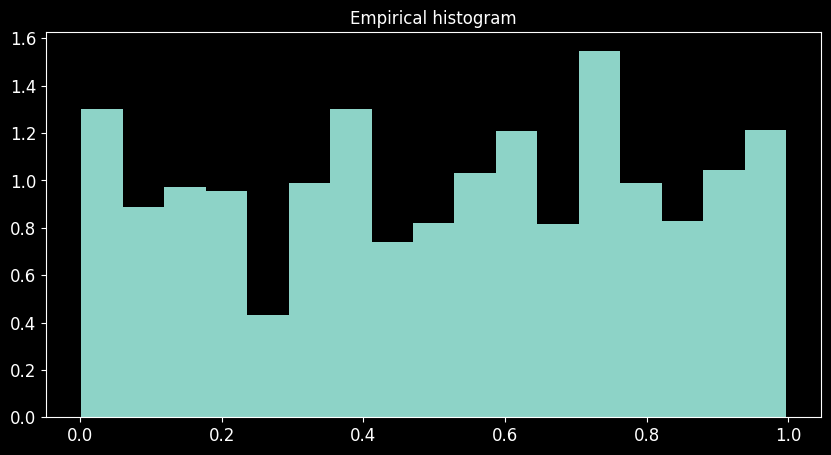

In [4]:
n = 5000

X = MidSquare(n,l=6,x_0 = 125698)

plt.figure(figsize=(10,5))
plt.hist(X,density=True,bins='auto')

plt.title("Empirical histogram")
plt.show()

This seems not ideal, but hard to pin down. However, if we instead just look at a scatter plot of the samples (i.e., plot $X_i$ vs. $i$ for $i\in\{1,2,\ldots,\text{number of samples}\}$, then we see a more problematic pattern (which is far from random!)

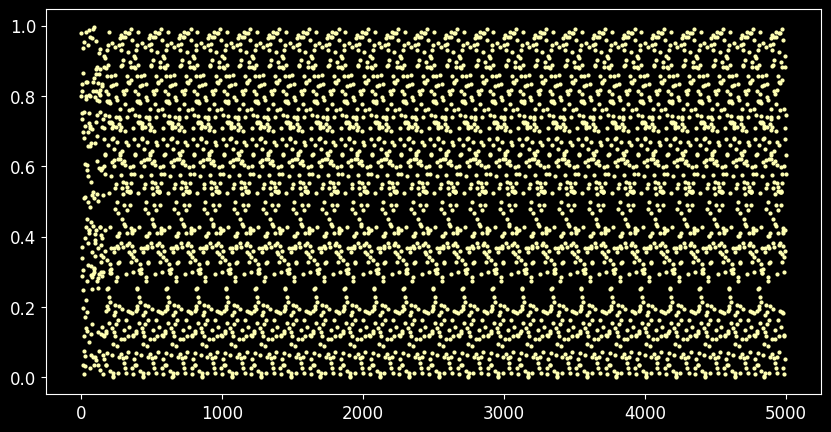

In [5]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(n)+1,X,s=4,color=cmap(1))
plt.show()

## Linear Congruential Generators

A more useful method to generate pseudorandom numbers is via *linear congruential generators*. To study this, we first write a function to generate pseudorandom numbers $(u_1,u_2,\ldots)$ according to the following rule: we start with a *seed* $x_0$, and then we generate the $n^th$ sample $u_n$ using the following update rule
\begin{align*}
    u_n &= \frac{x_n+1}{m+1} \\
	x_{n+1}  &=  (ax_n + c) \mbox{ mod }  m
\end{align*}
Note: This returns $u_i\in\left\{\frac{1}{m+1},\frac{2}{m+1},\ldots,\frac{m}{m+1}\right\}$. If instead we use  $u_n = \frac{x_n}{m}$, then we get $u_i\in\left\{0,\frac{1}{m},\frac{2}{m},\ldots,\frac{m-1}{m}\right\}$

Inputs: Length $n$, modulus $m$, multiplier $a$, increment $c$, seed $x_0$

In [6]:
def LCG(n, m=2**31-1, a=1103515245, c=12345, seed=1):
    """
    Generate a pseudorandom sequence using a Linear Congruential Generator (LCG).

    Parameters:
    n (int): The number of pseudorandom numbers to generate.
    m (int): The modulus value (default is 2^31-1, following glibc specifications).
    a (int): The multiplier value (default is 1103515245, following glibc specifications).
    c (int): The increment value (default is 12345, following glibc specifications).
    seed (int): The initial seed value (default is 1).

    Returns:
    numpy.ndarray: An array of pseudorandom numbers in the range [0, 1).
    """
    # Initialize an array to store the generated pseudorandom numbers
    output = np.zeros(n)

    x = seed
    for i in range(n):
        # Calculate the pseudorandom number and normalize it to [0, 1)
        output[i] = (x + 1.0) / (m + 1.0)

        # Update the LCG state using the specified parameters
        x = (a * x + c) % m

    return output

To visualize the output of an LCG, we can plot the sequence $x_n$ on a 'clock face' with numbers $\{0,1,2,\ldots,m-1\}$ (if you have done any modular arithmetic before, this should seem familiar)

In [7]:
def plot_clock_face(m, fig, annotate=False):
    """
    Plot points on a unit circle representing the LCG sequence on a clock face.

    Parameters:
    m (int): The modulus value for the LCG sequence.
    fig (matplotlib.figure.Figure): The figure object to draw on.
    annotate (bool): Whether to annotate points with their index.

    Returns:
    None
    """
    # Plot m points on the unit circle
    for i in range(m):
        theta = 2.0 * np.pi * i / m
        plt.plot(np.sin(theta), np.cos(theta), 'rs', markersize = 10)
        if annotate:
            plt.annotate(str(i), (np.pi/2 - theta, 1.05), xycoords='polar')

def plot_clock_path(m, x, fig, color='y'):
    """
    Plot the path of an LCG sequence on a clock face.

    Parameters:
    m (int): The modulus value for the LCG sequence.
    x (numpy.ndarray): The LCG sequence.
    fig (matplotlib.figure.Figure): The figure object to draw on.
    color (str): The color for the path.

    Returns:
    None
    """
    # Plot the seed node
    theta_0 = 2.0 * np.pi * (x[0] * (m + 1) - 1) / m
    plt.plot(np.sin(theta_0), np.cos(theta_0), 'gs', markersize = 10)

    # Plot the path of the LCG sequence
    for i in range(len(x) - 1):
        theta_start = 2.0 * np.pi * (x[i] * (m + 1) - 1) / m
        theta_end = 2.0 * np.pi * (x[i + 1] * (m + 1) - 1) / m
        x_start = np.sin(theta_start)
        y_start = np.cos(theta_start)
        del_x = np.sin(theta_end) - np.sin(theta_start)
        del_y = np.cos(theta_end) - np.cos(theta_start)
        if abs(del_x) > 0 or abs(del_y) > 0:
            plt.arrow(x_start, y_start, del_x, del_y,
                      length_includes_head=True, head_width=0.05, head_length=0.1, fc=color, ec=color)


Below we show how this works for a small value of $m$ (here, $m=8$). We indicate the seed node $x_0$ in green. Note that this setting of parameters leads to a *full period* generator: the path $(x_0,x_1,x_2,\ldots)$ starts at the seed, visits every other point in $\{0,1,\ldots,m-1\}$ before returning to the seed and starting over again.

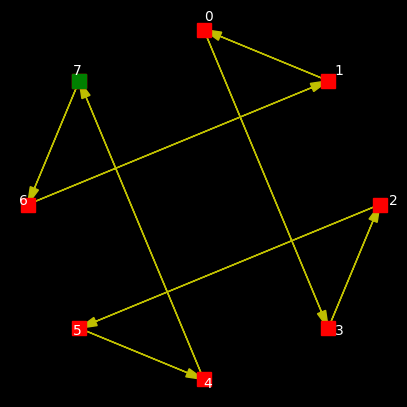

In [13]:
m = 8
a = 5
c = 3
seed = 7

fig = plt.figure(figsize=(5,5))
x = LCG(n=m+1,m=m,a=a,c=c,seed = seed)

plot_clock_face(m,fig,annotate = True)
plot_clock_path(m,x,fig)
#plt.axis('equal')
plt.axis('off')
plt.show()

For a full-period LCG, the sequence is the same irrespective of seed (can you see why?). If the period is not full, the sequence (and period) can depend on the seed. Below we show some examples of this

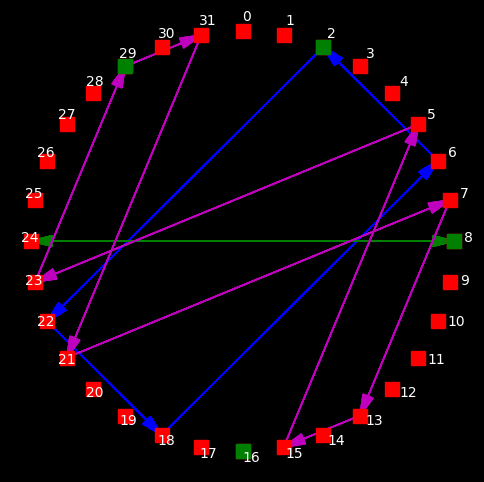

In [12]:
m = 32
a = 11
c = 0

fig = plt.figure(figsize=(6,6))

plot_clock_face(m,fig,annotate = True)

x = LCG(n=m+1,m=m,a=a,c=c,seed=2)
plot_clock_path(m,x,fig,color='b')
x = LCG(n=m+1,m=m,a=a,c=c,seed=8)
plot_clock_path(m,x,fig,color='g')
x = LCG(n=m+1,m=m,a=a,c=c,seed=29)
plot_clock_path(m,x,fig,color='m')
x = LCG(n=m+1,m=m,a=a,c=c,seed=16)
plot_clock_path(m,x,fig,color='c')

plt.axis('off')
plt.show()

We can animate this to see how things change as we vary $a$ and $c$ - notice that while some settings lead to full-period cycles (and even among them, some look more 'random' than others - for example, would you use $a=1,c=1$ for an PRNG?), other

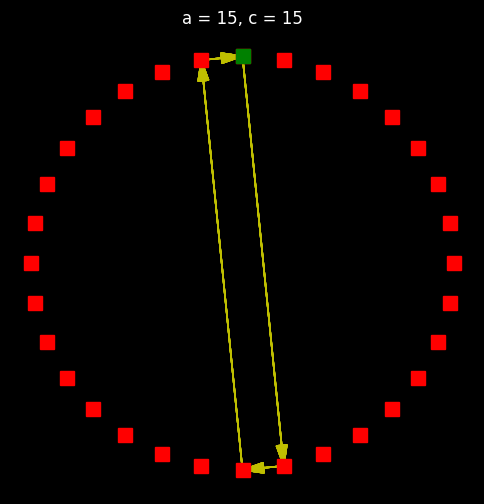

In [16]:
from IPython import display
import time

m = 32
c = 5
a = 1

for i in range(int(m/2)):
    a = i
    c = i
    display.clear_output(wait=True)
    x = LCG(n=m+1,m=m,a=a,c=c,seed=0)
    fig = plt.figure(figsize=(6,6))
    plot_clock_face(m,fig,annotate = False)
    plot_clock_path(m,x,fig)
    plt.title("a = "+str(a)+", c = "+str(c))
    #plt.axis('equal')
    plt.axis('off')
    plt.show()
    time.sleep(1)

#### Basic tests of performance of LCGs

The most basic thing we want to test is that the histogram of the LCG output is close to what we want. Try plotting the empirical histogram for some chosen values of parameters (and compare to the default settings, which have been set to parameters which are known to perform well)

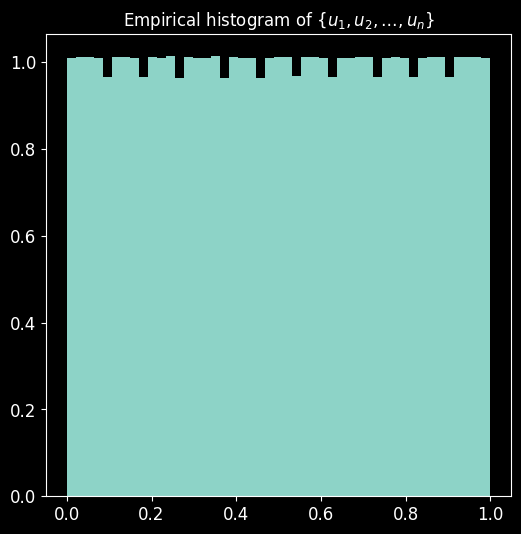

In [18]:
n = 100000

# A problematic parameter setting?
#X = LCG(n,m=2**10,a = 57,c=1)

# The default setting is a well-tested LCG used in practice
X = LCG(n)

plt.figure(figsize=(6,6))
plt.hist(X,density=True,bins='auto')
plt.title("Empirical histogram of $\{u_1,u_2,\ldots,u_n\}$")
plt.show()

We can also get a sense of the 'quality' (in particular, the period) of the LCG by looking at a scatter plot of samples

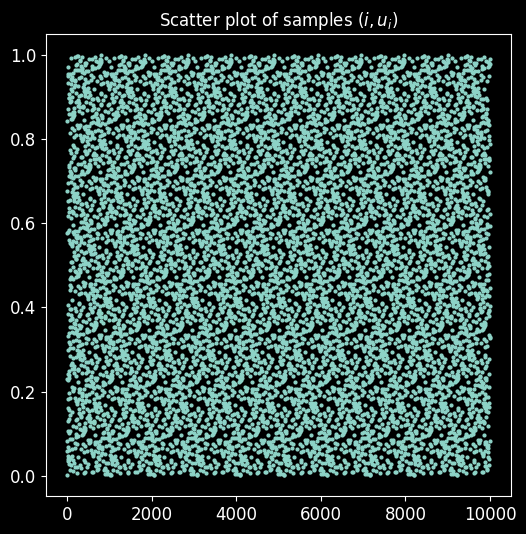

In [21]:
n = 10000
X = LCG(n,m=2**10,a = 57,c=1)
#X = LCG(n)

plt.figure(figsize=(6,6))
plt.scatter(np.arange(n)+1,X,s=4)
plt.title("Scatter plot of samples $(i,u_i)$")
plt.show()

## Theoretical deficiency of LCGs

While LCGs perform well on the histogram test, a bigger problem arises when we test the sequence for independence (remember, you want to use your PRNG to generate a stream of independent samples). The next demo shows that, nfortunately, for small values of $a,m$, and $c$,  the points
$
(U_0,U_1),~ (U_2,U_3), ~ (U_4,U_5), \ldots
$
lie on a relatively small number of parallel lines

(Ideal behavior: the points should be uniformly distributed in $[0,1]^2$)


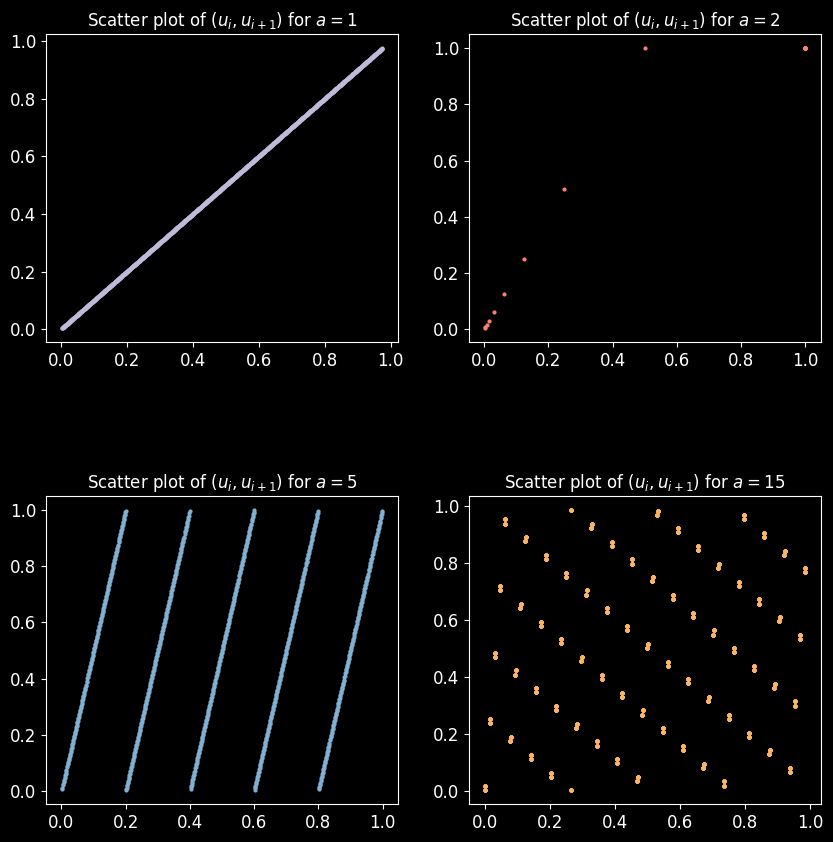

In [22]:
n = 1000

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=.5)
i = 0
for a in [1, 2, 5, 15]:
    i = i+1
    X = LCG(n,m=2**10,a = a,c=1)
    plt.subplot(2,2,i)
    plt.scatter(X[0:-2],X[1:-1],label='a=' + str(a),color=cmap(i+1),s=4)
    plt.title("Scatter plot of $(u_i,u_{i+1})$ for $a=$" + str(a))

plt.show()

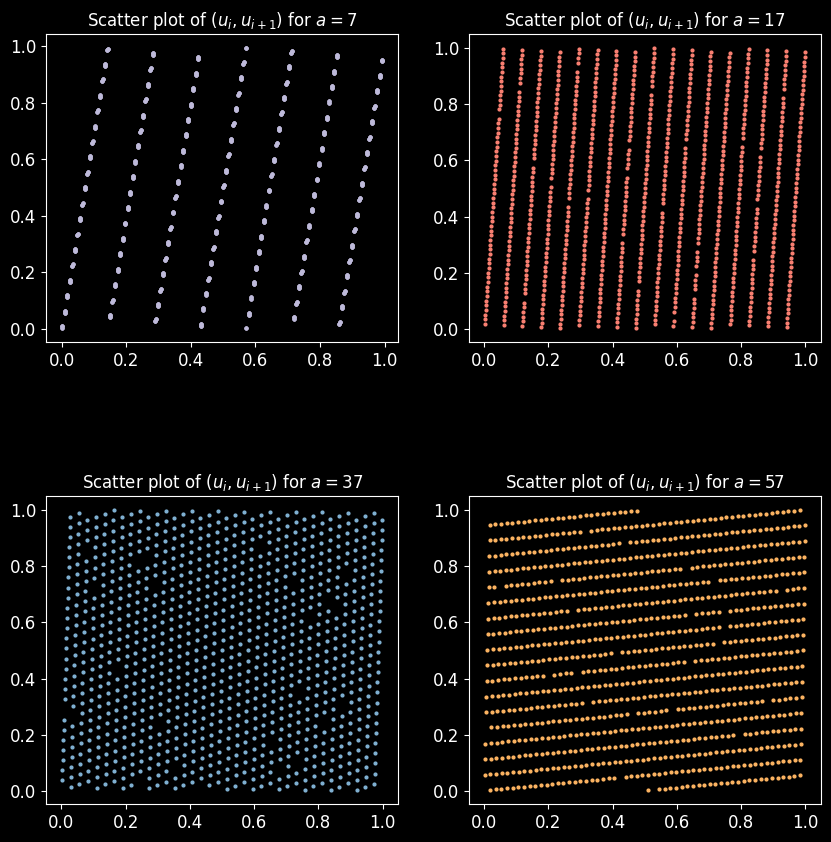

In [24]:
n = 1000

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=.5)
i = 0
for a in [7, 17, 37, 57]:
    i = i+1
    X = LCG(n,m=2**10,a = a,c=1)
    plt.subplot(2,2,i)
    plt.scatter(X[0:-2],X[1:-1],label='a=' + str(a),color=cmap(i+1),s=4)
    plt.title("Scatter plot of $(u_i,u_{i+1})$ for $a=$" + str(a))

plt.show()

You can see a similar issue by plotting triplets $(X_i,X_{i+1},X_{i+2})$ in 3d

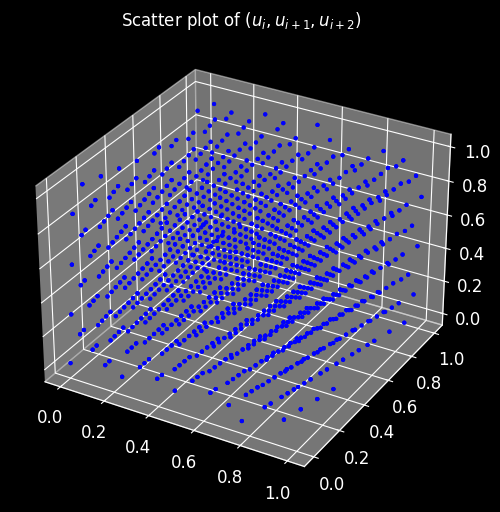

In [25]:
n = 5000
X = LCG(n,m=2**10,a = 17,c=1)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0:-3],X[1:-2],X[2:-1],s=4,color='blue')
plt.title("Scatter plot of $(u_i,u_{i+1},u_{i+2})$")

plt.show()

This issue however is not as significant when the parameters are more carefully chosen.

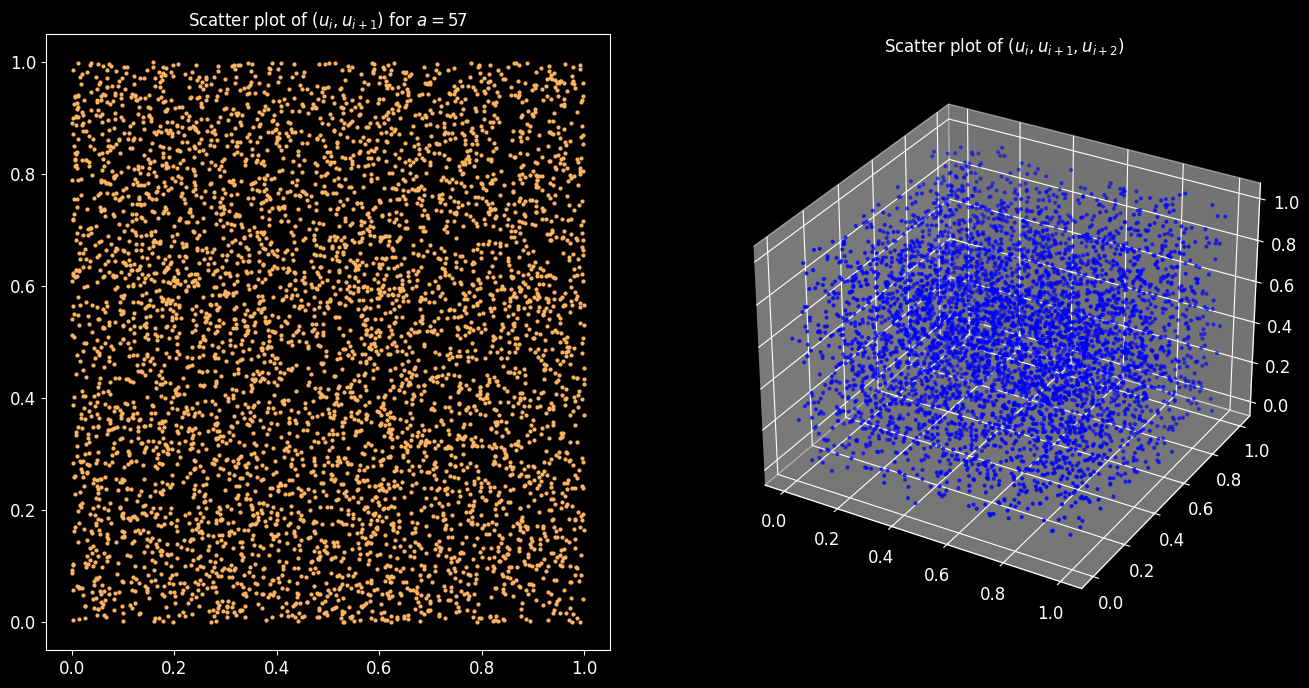

In [26]:
n = 5000
# Using our default choices
X = LCG(n)

fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(X[0:-2],X[1:-1],label='a=' + str(a),color=cmap(i+1),s=4)
plt.title("Scatter plot of $(u_i,u_{i+1})$ for $a=$" + str(a))


from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[0:-3],X[1:-2],X[2:-1],s=4,color='blue')
plt.title("Scatter plot of $(u_i,u_{i+1},u_{i+2})$")

plt.show()

## Box-Muller method for generating Normal rv

Finally, we see the first example of using a PRNG to get more complex random variables. Here, we show how to convert a pair of Uniform$[0,1]$ rv to a pair of Normal $\mathcal{N}(0,1)$ rv via the Box-Muller transform (see https://en.wikipedia.org/wiki/Box_Muller_transform; we will study this later in class). The following demo shows how a good histogram for the PRNG translates to a good histogram (i.e., one that is well fit by the Gaussian pdf) for the new samples; however, the earlier issue of pairwise dependence between successive samples now leads to a more complex dependence pattern.

In [27]:
def BoxMuller(n, rand_gen='default', params={}):
    """
    Generate pairs of normally distributed random numbers using the Box-Muller transform.

    Parameters:
    n (int): The number of pairs of normally distributed random numbers to generate.
    rand_gen (str): The random number generator to use ('default' or 'LCG').
    params (dict): Parameters for the LCG generator if rand_gen is 'LCG'.

    Returns:
    tuple: A tuple containing two arrays of normally distributed random numbers.
    """
    # Generate 2*n Uniform[0,1] random variables
    if rand_gen == 'default':
        u = np.random.rand(2 * n)
    elif rand_gen == 'LCG':
        try:
            u = LCG(2 * n, m=params.get('m', 2**31-1), a=params.get('a', 1103515245), c=params.get('c', 12345), seed=params.get('seed', 0))
        except KeyError:
            u = LCG(2 * n)

    # Set u_1 as the even entries and u_2 as the odd entries of u
    u_1 = u[0::2]
    u_2 = u[1::2]

    r = np.sqrt(-2.0 * np.log(u_1))
    theta = 2.0 * np.pi * u_2
    n_1 = r * np.cos(theta)
    n_2 = r * np.sin(theta)

    return n_1, n_2

Using the Box-Muller method with uniform random numbers from an LCG with non-ideal parameter settings (i.e., small $a,c$)

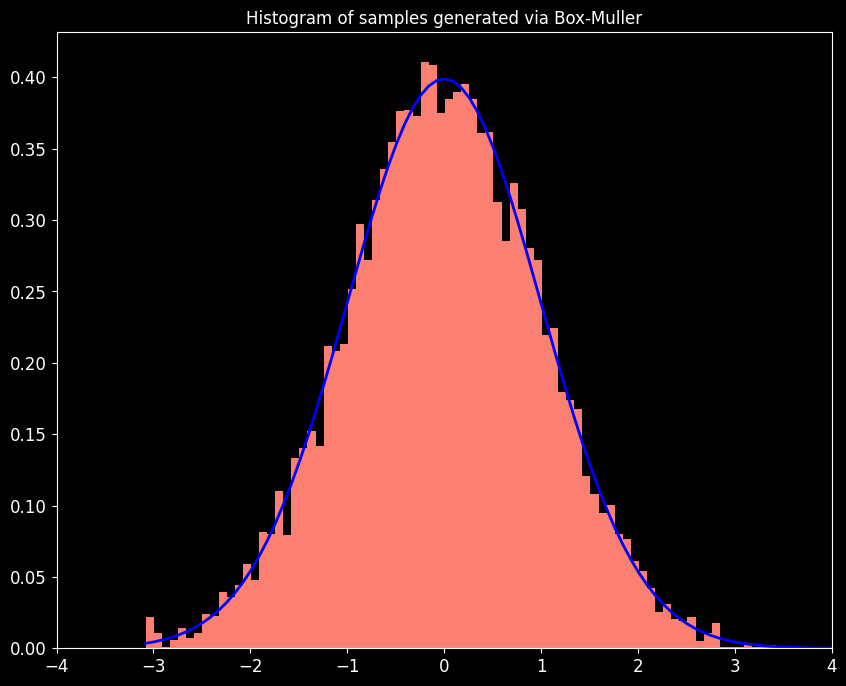

In [34]:
N = 10000
X_1,X_2 = BoxMuller(N,rand_gen='LCG',params = {'m':2**20,'a':57,'c':1,'seed':0})

plt.figure(figsize=(10,8))
n, bins, patches = plt.hist(X_1,bins = 100,density=True,color = cmap(3))
y = stats.norm.pdf(bins,0,1)
plt.xlim(-4,4)
plt.plot(bins, y, 'b', linewidth=2)
plt.title('Histogram of samples generated via Box-Muller')
plt.show()

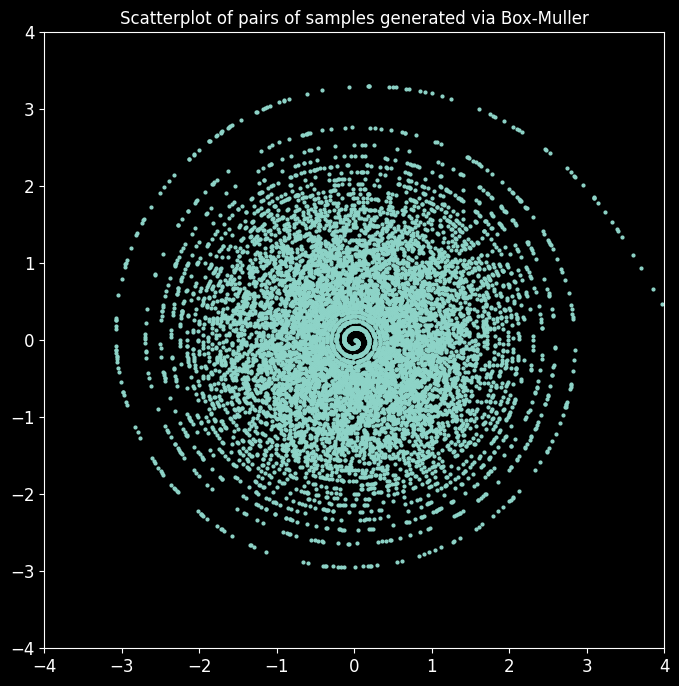

In [35]:
plt.figure(figsize=(8,8))
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.scatter(X_1,X_2,s=4)
plt.title('Scatterplot of pairs of samples generated via Box-Muller')
plt.show()

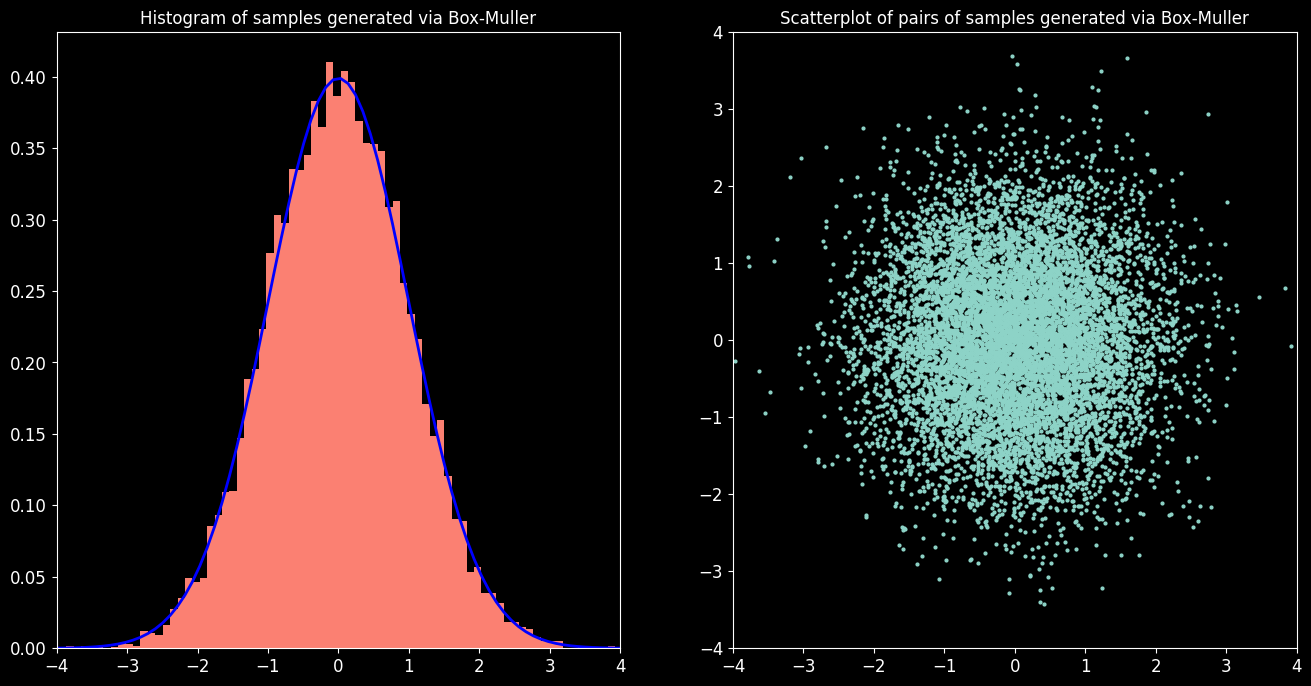

In [36]:
N = 10000
X_1,X_2 = BoxMuller(N,rand_gen='LCG')

fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
n, bins, patches = plt.hist(X_1,bins = 100,density=True,color = cmap(3))
y = stats.norm.pdf(bins,0,1)
plt.xlim(-4,4)
plt.plot(bins, y, 'b', linewidth=2)
plt.title('Histogram of samples generated via Box-Muller')


plt.subplot(1,2,2)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.scatter(X_1,X_2,s=4)
plt.title('Scatterplot of pairs of samples generated via Box-Muller')

plt.show()